<div align="center">

# Exercise Sheet 6: Data Science Methods  
## Technische Universität München 
### Winter semester 2024-2025

</div>


In [28]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import yfinance as yf

## 1. Exercise: Numerical Integration

### Write a function in Python that implements the trapezoid method in one dimension for estimating the integral of a function $f$ in a given interval $(a, b)$.

In [29]:
def trapezoid(f, a, b, n=1_000):
    dx = (b - a)/n
    x_arr = np.linspace(a, b, n+1)
    f_arr = f(x_arr)
    f_ini = f_arr[:-1]
    f_fin = f_arr[1:]
    f_sum = (f_ini + f_fin).sum()
    I = f_sum / 2 * dx
    return I

## 2. Exercise: Model Selection

###  2.1 Load the file `EUR_USD_exchange_rate.csv` into your working environment to use it as the dataset for this analysis. Each row corresponds to the exchange rate at the end of one day. Determine the output of our Bernoulli experiment for each day (except for the first one, which has no day before).

In [30]:
# Global variables
q0 = 0.5

In [31]:
# Upload data
data = pd.read_csv("EUR_USD_exchange_rate.csv")
data = data["Close"]

In [32]:
data.size

5489

In [33]:
# Construct the relative change of the price in %
changes = 100*np.diff(data)/data[:-1].to_numpy()

# Determine if the day's retuns have the same sign as the day before
Bernoulli_ouput = (changes[:-1] * changes[1:] > 0)
print(Bernoulli_ouput)

[ True False False ... False False False]


### 2.2 Assuming that daily returns are independent of each other, calculate the Bayes factor $K$. For the integral over the success probability $q$ use your implementation of the trapezoid method from Exercise 1. Is there a preference for one model over the other based on the data?

In [34]:
# A number of n independent Bernoulli experiments with the same success probability q are equivalent to one Binomial experiment Binomial(n, q). Hence
n = len(changes) # Number of days we perform the Bernoulli experiment
k = Bernoulli_ouput.sum() # Number of successes 
print(f"n = {n}, k = {k}")

num = sp.stats.binom.pmf(k, n, q0) # P(Data | M0)
L = lambda q : sp.stats.binom.pmf(k, n, q) # Likelihood with unknown parameter q.
denom = trapezoid(L, 0, 1) # P(Data | M1)
K = num / denom

print(num, denom)
print(f"Bayes factor K = {K}.") 

if K < 3.2:
    s = "Not worth more than a bare mention."
elif 3.2 <= K and K < 1e1:
    s = "Substantial."
elif 1e1 <= K and K < 1e2:
    s = "Strong."
elif 1e2 <= K:
    s = "Decisive."
else:
    s = "Undetermined."
print("Strength of evidence: " + s)

n = 5488, k = 2641
0.00022544064255161623 0.00018218254691201058
Bayes factor K = 1.2374436869657892.
Strength of evidence: Not worth more than a bare mention.


### 2.3 We want to compare this procedure to the classical approach. Construct the LRT and assuming Wilk's theorem applies (which it does), compute the p-value and decide whether or not the null hypothesis can be rejected with a significance level of $\alpha = 0.05$. Interpret the results.

In [35]:
# To construct the LRT, we need the MLE of our parameter of interest q:
q_MLE = k/n

# For curiosity, we also compute the MLE of the standard deviation
sigma_q_MLE = np.sqrt((k/n*(1-k/n))/n)
print(f"q_MLE = {q_MLE}")
print(f"sigma_MLE = {sigma_q_MLE}")

q_MLE = 0.48123177842565595
sigma_MLE = 0.006744609037415767


In [41]:
alpha = 0.05 # significance level
print(f"Significance level alpha = {alpha}")
p_value = 1 - sp.stats.chi2.cdf(LRT, df=1)
print(f"p-value = {p_value}")

LRT = -2 * np.log(num / sp.stats.binom.pmf(k, n, q_MLE)) # Observed value
print(f"Obseved value LRT = {LRT}")

LRT_cutoff = sp.stats.chi2.ppf(1-alpha, df=1)
print(f"Cutoff value for LRT = {LRT_cutoff}")

if LRT <= LRT_cutoff: # equivalent: p_value >= alpha
    print("Null hypothesis cannot be rejected from the data.")
else:
    print("We reject the null hypothesis.")

Significance level alpha = 0.05
p-value = 0.0054180839472668385
Obseved value LRT = 7.73432414336255
Cutoff value for LRT = 3.841458820694124
We reject the null hypothesis.


In contrast to the classical LRT, the Bayesian approach penalizes the complexity of a model, which makes $M_0$ consistent with our data. Talk about the std in the frequentist approach being too small and that is why M0 can be rejected.

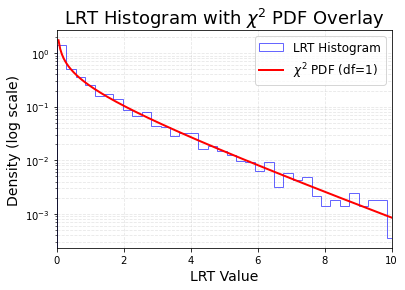

In [37]:
# Checking that Wilk's theorem holds:
N = 10_000 # Number of simulations
k_sim = sp.stats.bernoulli.rvs(q0, size=(n, N)).sum(axis=0) # Simulated data, given the null hypothesis. We generate n Bernoulli experiments and we count how many successes we had.
q_MLE_sim = k_sim/n # q MLE for Bernoulli experiments.
num_sim = sp.stats.binom.pmf(k_sim, n, q0) # Likelihood given the null hypothesis.
LRT_arr = -2 * np.log(num_sim / sp.stats.binom.pmf(k_sim, n, q_MLE_sim))

# Histogram of LRT_arr
plt.hist(LRT_arr, bins=50, density=True, color='blue', alpha=0.6, label='LRT Histogram', histtype='step')

# Overlay chi-squared distribution (df=1)
X = np.linspace(0, 10, 200)
plt.plot(X, sp.stats.chi2.pdf(X, df=1), color='red', linewidth=2, label=r'$\chi^2$ PDF (df=1)')

plt.yscale('log')
plt.title('LRT Histogram with $\chi^2$ PDF Overlay', fontsize=18)
plt.xlabel('LRT Value', fontsize=14)
plt.ylabel('Density (log scale)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3, which='both', linestyle='--')
plt.xlim(0, 10)
plt.show()

In [38]:
q_MLE, sigma_q = k/n, np.sqrt((k/n*(1-k/n))/n)
q_MLE, sigma_q

(0.48123177842565595, 0.006744609037415767)

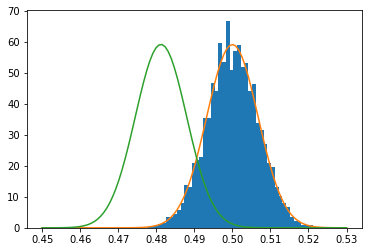

In [45]:
N = 10_000
q0 = 0.5
sigma0 = np.sqrt(q0*(1-q0)/n)
x = sp.stats.bernoulli.rvs(q0, size=(n, N))
X = np.linspace(0.45, 0.53, 100)
Y = sp.stats.norm.pdf(X, loc=q0, scale=sigma0)
plt.hist(x.mean(axis=0), bins=50, density=True)
plt.plot(X, Y)
Y1 = sp.stats.norm.pdf(X, loc=q_MLE, scale=sigma_q_MLE)
plt.plot(X, Y1)

## 3. Markov Chain Monte Carlo (MCMC)

### 3.1 Generate the sample that we will use as data and illustrate the generated data.

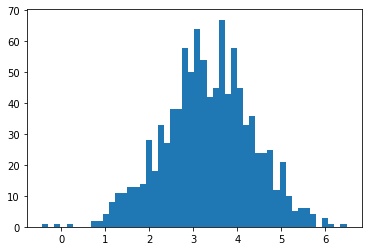

In [417]:
# Generate data
theta0 = -3.3
sigma=1
n_total = 1000
data = sp.stats.norm.rvs(abs(theta0), sigma, size=n_total)

# Illustrate data
plt.hist(data, bins=50)
plt.show()

### 3.2 Apply the Metropolis algorithm to estimate the posterior distribution $P\left(\theta | \text{data}\right)$. Assume a flat prior (uniform distribution $ P(\theta) \sim U(-30, 30)$) and a Gaussian proposal distribution $g(y | x) \sim \mathcal{N}\left(x, \tau^2 = 10^2\right)$, where $x$ represents the current state and $y$ the proposed new state in the Markov chain.

In [421]:
# Log-likelihood (llh)
def llh(data, theta):
    return np.sum(sp.stats.norm.logpdf(data, loc=abs(theta), scale=sigma))

# Metropolis acceptance ratio in log-space
def ratio_llh(data, x_new, x_old, prior):
    r1 = llh(data, x_new) + np.log(prior(x_new))
    r2 = llh(data, x_old) + np.log(prior(x_old))
    r = r1 - r2
    return r

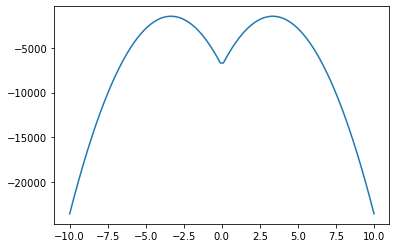

In [439]:
 # Illustrate the llh
theta_arr = np.linspace(-10, 10, 100)
llh_arr = []
for theta in theta_arr:
    llh_arr.append(llh(data, theta))
llh_arr = np.array(llh_arr)
plt.plot(theta_arr, llh_arr)
plt.show()

In [429]:
# Implementation of Metropolis algorithm
def Metropolis_algo(data, starting_point, prior, proposal_distr, n_steps=10_000):
    samples = [starting_point] # starting point
    for i in range(n_steps):
        x = samples[-1]
        y = proposal_distr(x).rvs() # proposal distr. with tau=5
        r = ratio_llh(data, y, x, prior)
        u = np.log(sp.stats.uniform.rvs()) # we need to apply the log since we are working with llh
        if r > u:
            samples.append(y)
        else:
            samples.append(x)
    return samples

In [436]:
# Metropolis algorithm with tau = 5
starting_point = 0
prior = lambda theta : sp.stats.uniform.pdf(theta, loc=-30, scale=60) 
tau = 5
proposal_distr = lambda x : sp.stats.norm(loc=x, scale=tau)
samples = Metropolis_algo(data, starting_point, prior, proposal_distr)

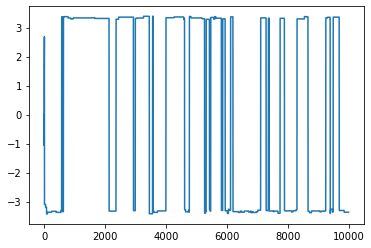

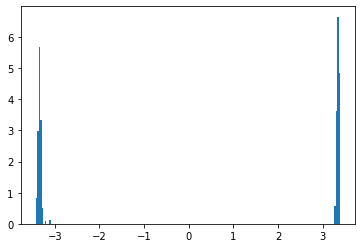

In [437]:
# Trace of Markov chain to visualize what is happening
plt.plot(range(len(samples)), samples)
plt.show()

# Posterior distribution P(theta | data)
samples = np.array(samples)
plt.hist(samples, bins=200, density=True)
plt.show()

### 3.3  Now try $\tau = 1$ and discuss your results in contrast to $\tau = 5$.

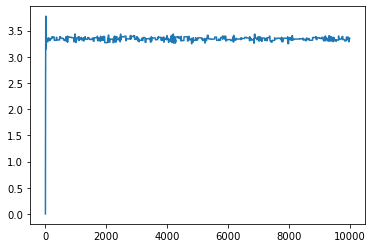

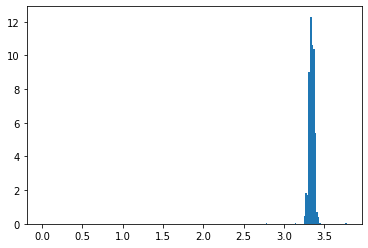

In [438]:
# Metropolis algorithm with tau = 1
starting_point = 0
prior = lambda theta : sp.stats.uniform.pdf(theta, loc=-30, scale=60) 
tau = 1
proposal_distr = lambda x : sp.stats.norm(loc=x, scale=tau)
samples = Metropolis_algo(data, starting_point, prior, proposal_distr)

# Trace of Markov chain to visualize what is happening
plt.plot(range(len(samples)), samples)
plt.show()

# Posterior distribution P(theta | data)
samples = np.array(samples)
plt.hist(samples, bins=200, density=True)
plt.show()

As we could see before, the posterior is bimodal since the likelihood is invariant under reflection ($\theta \rightarrow -\theta$). A too localized proposal distribution $g(y|x)$ will not find one of the peaks.